# Baseline submission
Baseline solution presented during Tutorial 5. The method is defined as follows:
1. normalization of each item
2. imputation of missing values as 0s
3. SVD with *k=3*
4. SVD result used as initialization for ASL
5. ALS with *k = 3*, *λ = 0.1* for 20 iterations

Expected public score: 0.98777


In [1]:
n_movies = 1000
n_users = 10000

### Step 0: Data loading

In [2]:
import pandas as pd
import numpy as np

# load training data
data_pd = pd.read_csv('../data/data_train.csv') 
data_pd

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5
...,...,...
1176947,r9990_c1000,4
1176948,r9992_c1000,5
1176949,r9994_c1000,3
1176950,r9997_c1000,4


In [3]:
# get users, movies
users, movies = [np.squeeze(arr) 
                  for arr in np.split( data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
# get predictions
predictions = data_pd.Prediction.values

In [4]:
# create data matrix
data = np.full((n_users, n_movies), np.nan)
data.shape

(10000, 1000)

In [5]:
# populate data matrix
for user, movie, pred in zip(users, movies, predictions): 
    data[user][movie] = pred
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  5.,  3.,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan,  3.]])

### Step 1: Normalization

In [6]:
# save mean and std to invert zscore
mean_std = []
for j in range(data.shape[1]):
    mean = np.nanmean(data[:, j])
    std = np.nanstd(data[:, j])
    mean_std.append((mean, std))

In [7]:
from scipy import stats

# normalize data using z-score
data = stats.zscore(data, axis=1, nan_policy='omit')

### Step 2: Imputation

In [8]:
from sklearn.impute import SimpleImputer

data = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(data)

### Step 3: SVD

In [9]:
# SVD decomposition
U, s, Vt = np.linalg.svd(data, full_matrices=False)
# Using the top k eigenvalues, k=3
k = 3
S = np.zeros((n_movies, n_movies)) 
S[:k, :k] = np.diag(s[:k])

### Steps 4 and 5: ASL

In [10]:
# given parameters
k = 3
λ = 0.1
n_iters = 20

In [11]:
from sklearn.metrics import mean_squared_error

# define ASL model
class ASL:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    k : int
        number of latent factors to use in matrix 
        factorization model (rank)
        
    λ : float
        regularization term for item/user latent factors
    """

    def __init__(self, n_iters, k, λ):
        self.λ = λ
        self.n_iters = n_iters
        self.k = k  
        
    def fit(self, data, U, V):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_movies = data.shape
        self.U = U
        self.V = V
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.U = self._als_step(data.T, self.U, self.V)
            self.V = self._als_step(data, self.V, self.U) 
            predictions = self.predict()
            train_mse = self.compute_mse(data, predictions)
            self.train_mse_record.append(train_mse)
    
    def _als_step(self, data, to_solve, fixed):
        """alternating least square step"""
        to_solve = np.linalg.solve(fixed.dot(fixed.T) + self.λ * np.eye(self.k),
                                   fixed.dot(data))
        return to_solve
    
    def predict(self):
        """predict ratings for every user and item"""
        return self.U.T.dot(self.V)
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [12]:
# initialize U and V
U = U[:, :k].T
V = np.dot(S[:k, :k], Vt[:k, :])

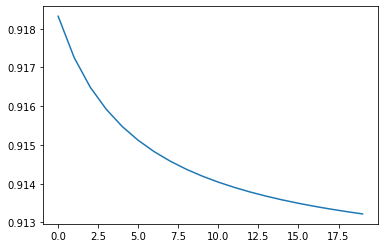

In [13]:
import matplotlib.pyplot as plt

# fit the model and plot the loss
model = ASL(n_iters, k, λ)
model.fit(data, U, V)
plt.plot(range(20), model.train_mse_record)


In [14]:
# make predictions
pred = model.predict()

### Generate submission

Generate .zip submission.

In [15]:
# load sample submission
sample = pd.read_csv('../data/sampleSubmission.csv') 

In [16]:
import re

for index, row in sample.iterrows():
    r, c = re.findall(r'r(\d+)_c(\d+)', row["Id"])[0]
    sample.at[index, "Prediction"] = pred[int(r)-1][int(c)-1]*mean_std[int(c)-1][1]+mean_std[int(c)-1][0]

sample

,Id,Prediction
0,r37_c1,3.340319
1,r73_c1,3.371846
2,r156_c1,3.335591
3,r160_c1,3.325259
4,r248_c1,3.368914
...,...,...
1176947,r9974_c1000,3.682695
1176948,r9977_c1000,3.601329
1176949,r9978_c1000,3.635732
1176950,r9982_c1000,3.650845


In [17]:
sample.to_csv("submission.zip", compression="zip", float_format='%.3f', index = None)

Submit the solution to Kaggle.

In [ ]:
!kaggle competitions submit -c cil-collaborative-filtering-2022 -f submission.zip -m "30 iterations"